# XGBoost

In this notebook, we will try to use XGBoost alogrythm

### Load and prepare the dataset

In [21]:
from preprocess_data import get_HITL, clean_HITL
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

BASE_PATH = "../../data/"
random_state = 42

In [7]:
hitl_dict = get_HITL("../../data/HardwareInTheLoop/", small=True)
df_network, df_physical = clean_HITL(hitl_dict) # Clean-up helper function

print("Network dataset shape: ", df_network.shape)
print("Physical dataset shape: ", df_physical.shape)

Network dataset shape:  (243065, 17)
Physical dataset shape:  (9206, 44)


In [8]:
df_network_labels = df_network[["label_n", "label", "attack"]]
df_network = df_network.drop(columns=["label", "label_n", "attack"])
df_network_labels.head()

,label_n,label,attack
0,0,normal,1
1,0,normal,1
2,0,normal,1
3,0,normal,1
4,0,normal,1


In [9]:
from mlsecu.data_exploration_utils import get_column_names, get_nb_of_dimensions, get_nb_of_rows, get_object_column_names, get_number_column_names
from mlsecu.anomaly_detection_use_case import *
from mlsecu.data_preparation_utils import get_one_hot_encoded_dataframe, remove_nan_through_mean_imputation

Let's just be sure that we are not omitting any important column

In [10]:
assert(len(get_number_column_names(df_network)) + len(get_object_column_names(df_network)) == len(df_network.columns))

In [11]:
df_network[get_number_column_names(df_network)]

,time,sport,dport,flags,size,n_pkt_src,n_pkt_dst
0,1.617993e+09,56666.0,502.0,11000.0,66,50.0,15.0
1,1.617993e+09,502.0,56666.0,11000.0,64,15.0,50.0
2,1.617993e+09,56668.0,502.0,11000.0,66,50.0,15.0
3,1.617993e+09,502.0,56668.0,11000.0,65,15.0,50.0
4,1.617993e+09,502.0,56666.0,11000.0,65,15.0,50.0
...,...,...,...,...,...,...,...
243060,1.617971e+09,61516.0,502.0,11000.0,66,50.0,15.0
243061,1.617971e+09,61516.0,502.0,11000.0,66,50.0,15.0
243062,1.617971e+09,61517.0,502.0,11000.0,66,51.0,14.0
243063,1.617971e+09,61515.0,502.0,11000.0,66,47.0,14.0


In [12]:
df_network[get_object_column_names(df_network)]

,mac_s,mac_d,ip_s,ip_d,proto,modbus_fn,modbus_response
0,74:46:a0:bd:a7:1b,e6:3f:ac:c9:a8:8c,84.3.251.20,84.3.251.101,Modbus,Read Holding Registers,NaN
1,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,Modbus,Read Coils Response,[0]
2,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,Modbus,Read Holding Registers,NaN
3,fa:00:bc:90:d7:fa,74:46:a0:bd:a7:1b,84.3.251.103,84.3.251.20,Modbus,Read Holding Registers Response,[0]
4,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,Modbus,Read Holding Registers Response,[0]
...,...,...,...,...,...,...,...
243060,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,Modbus,Read Holding Registers,NaN
243061,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,Modbus,Read Holding Registers,NaN
243062,74:46:a0:bd:a7:1b,0a:fe:ec:47:74:fb,84.3.251.20,84.3.251.102,Modbus,Read Holding Registers,NaN
243063,74:46:a0:bd:a7:1b,e6:3f:ac:c9:a8:8c,84.3.251.20,84.3.251.101,Modbus,Read Holding Registers,NaN


##### Remove NaN values for both numerical and categorical columns

In [13]:
df_number_network = remove_nan_through_mean_imputation(df_network[get_number_column_names(df_network)])
df_number_network

,time,sport,dport,flags,size,n_pkt_src,n_pkt_dst
0,1.617993e+09,56666.0,502.0,11000.0,66,50.0,15.0
1,1.617993e+09,502.0,56666.0,11000.0,64,15.0,50.0
2,1.617993e+09,56668.0,502.0,11000.0,66,50.0,15.0
3,1.617993e+09,502.0,56668.0,11000.0,65,15.0,50.0
4,1.617993e+09,502.0,56666.0,11000.0,65,15.0,50.0
...,...,...,...,...,...,...,...
243060,1.617971e+09,61516.0,502.0,11000.0,66,50.0,15.0
243061,1.617971e+09,61516.0,502.0,11000.0,66,50.0,15.0
243062,1.617971e+09,61517.0,502.0,11000.0,66,51.0,14.0
243063,1.617971e+09,61515.0,502.0,11000.0,66,47.0,14.0


The two categorical columns with NaN values are `modbus_response` and `modbus_fn`. Let's replace the NaN values with empty strings

In [15]:
df_object_network = df_network[get_object_column_names(df_network)].fillna("")
df_object_network

,mac_s,mac_d,ip_s,ip_d,proto,modbus_fn,modbus_response
0,74:46:a0:bd:a7:1b,e6:3f:ac:c9:a8:8c,84.3.251.20,84.3.251.101,Modbus,Read Holding Registers,
1,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,Modbus,Read Coils Response,[0]
2,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,Modbus,Read Holding Registers,
3,fa:00:bc:90:d7:fa,74:46:a0:bd:a7:1b,84.3.251.103,84.3.251.20,Modbus,Read Holding Registers Response,[0]
4,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,Modbus,Read Holding Registers Response,[0]
...,...,...,...,...,...,...,...
243060,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,Modbus,Read Holding Registers,
243061,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,Modbus,Read Holding Registers,
243062,74:46:a0:bd:a7:1b,0a:fe:ec:47:74:fb,84.3.251.20,84.3.251.102,Modbus,Read Holding Registers,
243063,74:46:a0:bd:a7:1b,e6:3f:ac:c9:a8:8c,84.3.251.20,84.3.251.101,Modbus,Read Holding Registers,


Merge the two sub-datasets

In [26]:
df_network_prepared = pd.concat([df_number_network, df_object_network], axis=1)
df_network_prepared.head()

,time,sport,dport,flags,size,n_pkt_src,n_pkt_dst,mac_s,mac_d,ip_s,ip_d,proto,modbus_fn,modbus_response
0,1.617993e+09,56666.0,502.0,11000.0,66,50.0,15.0,74:46:a0:bd:a7:1b,e6:3f:ac:c9:a8:8c,84.3.251.20,84.3.251.101,Modbus,Read Holding Registers,
1,1.617993e+09,502.0,56666.0,11000.0,64,15.0,50.0,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,Modbus,Read Coils Response,[0]
2,1.617993e+09,56668.0,502.0,11000.0,66,50.0,15.0,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,Modbus,Read Holding Registers,
3,1.617993e+09,502.0,56668.0,11000.0,65,15.0,50.0,fa:00:bc:90:d7:fa,74:46:a0:bd:a7:1b,84.3.251.103,84.3.251.20,Modbus,Read Holding Registers Response,[0]
4,1.617993e+09,502.0,56666.0,11000.0,65,15.0,50.0,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,Modbus,Read Holding Registers Response,[0]


In [27]:
df_network_prepared.reset_index(drop=True, inplace=True)

In [30]:
# convert categorical features to category type so that XGBoost can handle them
cats = get_object_column_names(df_network_prepared)
for col in cats:
    df_network_prepared[col] = df_network_prepared[col].astype('category')

In [31]:
df_network_prepared.head()

,time,sport,dport,flags,size,n_pkt_src,n_pkt_dst,mac_s,mac_d,ip_s,ip_d,proto,modbus_fn,modbus_response
0,1.617993e+09,56666.0,502.0,11000.0,66,50.0,15.0,74:46:a0:bd:a7:1b,e6:3f:ac:c9:a8:8c,84.3.251.20,84.3.251.101,Modbus,Read Holding Registers,
1,1.617993e+09,502.0,56666.0,11000.0,64,15.0,50.0,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,Modbus,Read Coils Response,[0]
2,1.617993e+09,56668.0,502.0,11000.0,66,50.0,15.0,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,Modbus,Read Holding Registers,
3,1.617993e+09,502.0,56668.0,11000.0,65,15.0,50.0,fa:00:bc:90:d7:fa,74:46:a0:bd:a7:1b,84.3.251.103,84.3.251.20,Modbus,Read Holding Registers Response,[0]
4,1.617993e+09,502.0,56666.0,11000.0,65,15.0,50.0,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,Modbus,Read Holding Registers Response,[0]


In [32]:
def update_labels(df_labels):
    df_labels = df_labels.reset_index(drop=True)

    df_labels["new_labels"] = df_labels["label"].astype('category').cat.codes

    return df_labels

df_network_labels = update_labels(df_network_labels)

### Train XGBoost model

In [33]:
# Prepare train and test datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_network_prepared, df_network_labels[["new_labels", "label_n"]], test_size=0.2, random_state=random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((194452, 14), (48613, 14), (194452, 2), (48613, 2))

In [82]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train["label_n"], enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test["label_n"], enable_categorical=True)

params = {"objective": "binary:logistic", "tree_method": "hist", "seed": random_state}
n = 200

evals = [(dtest, "validation"), (dtrain, "train")]

model = xgb.train(params, dtrain, n, evals=evals, verbose_eval=10)

/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/xgboost/data.py:463: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/xgboost/data.py:464: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_categorical_dtype(dtype) and enable_categorical)
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype 

[0]	validation-logloss:0.44187	train-logloss:0.44326
[10]	validation-logloss:0.20703	train-logloss:0.20698
[20]	validation-logloss:0.18189	train-logloss:0.18117
[30]	validation-logloss:0.16802	train-logloss:0.16656
[40]	validation-logloss:0.16135	train-logloss:0.15968
[50]	validation-logloss:0.15766	train-logloss:0.15523
[60]	validation-logloss:0.15525	train-logloss:0.15225
[70]	validation-logloss:0.15401	train-logloss:0.15031
[80]	validation-logloss:0.15287	train-logloss:0.14862
[90]	validation-logloss:0.15221	train-logloss:0.14733
[100]	validation-logloss:0.15142	train-logloss:0.14611
[110]	validation-logloss:0.15086	train-logloss:0.14507
[120]	validation-logloss:0.15072	train-logloss:0.14430
[130]	validation-logloss:0.15058	train-logloss:0.14363
[140]	validation-logloss:0.15037	train-logloss:0.14293
[150]	validation-logloss:0.15032	train-logloss:0.14244
[160]	validation-logloss:0.15053	train-logloss:0.14168
[170]	validation-logloss:0.15038	train-logloss:0.14113
[180]	validation-logl

In [65]:
preds = model.predict(dtest)

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("Accuracy: ", accuracy_score(y_test["label_n"], preds.round()))
print("Precision: ", precision_score(y_test["label_n"], preds.round()))
print("Recall: ", recall_score(y_test["label_n"], preds.round()))
print("F1: ", f1_score(y_test["label_n"], preds.round()))
print("ROC AUC: ", roc_auc_score(y_test["label_n"], preds))

Accuracy:  0.9233538353938247
Precision:  0.896706214220526
Recall:  0.8133042365866506
F1:  0.8529713519059269
ROC AUC:  0.9803475767946427


<Axes: >

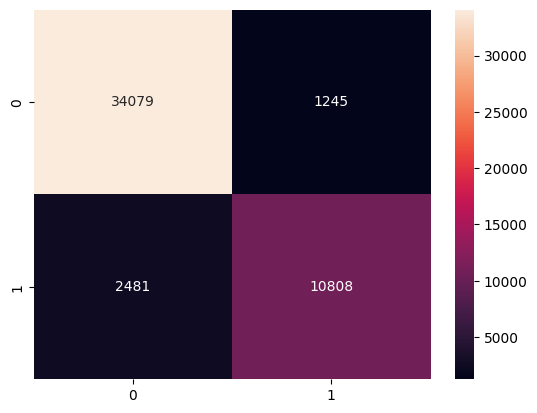

In [67]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test["label_n"], preds.round())
sns.heatmap(confusion_matrix(y_test["label_n"], preds.round()), annot=True, fmt="d")

Performance are pretty good as we achieve 92% of accuracy on the test dataset which is better than the LSTM or the MLP

Let's see which feature is the most important

Text(0.5, 1.0, 'Ordering of features by importance to the model learnt - using gain')

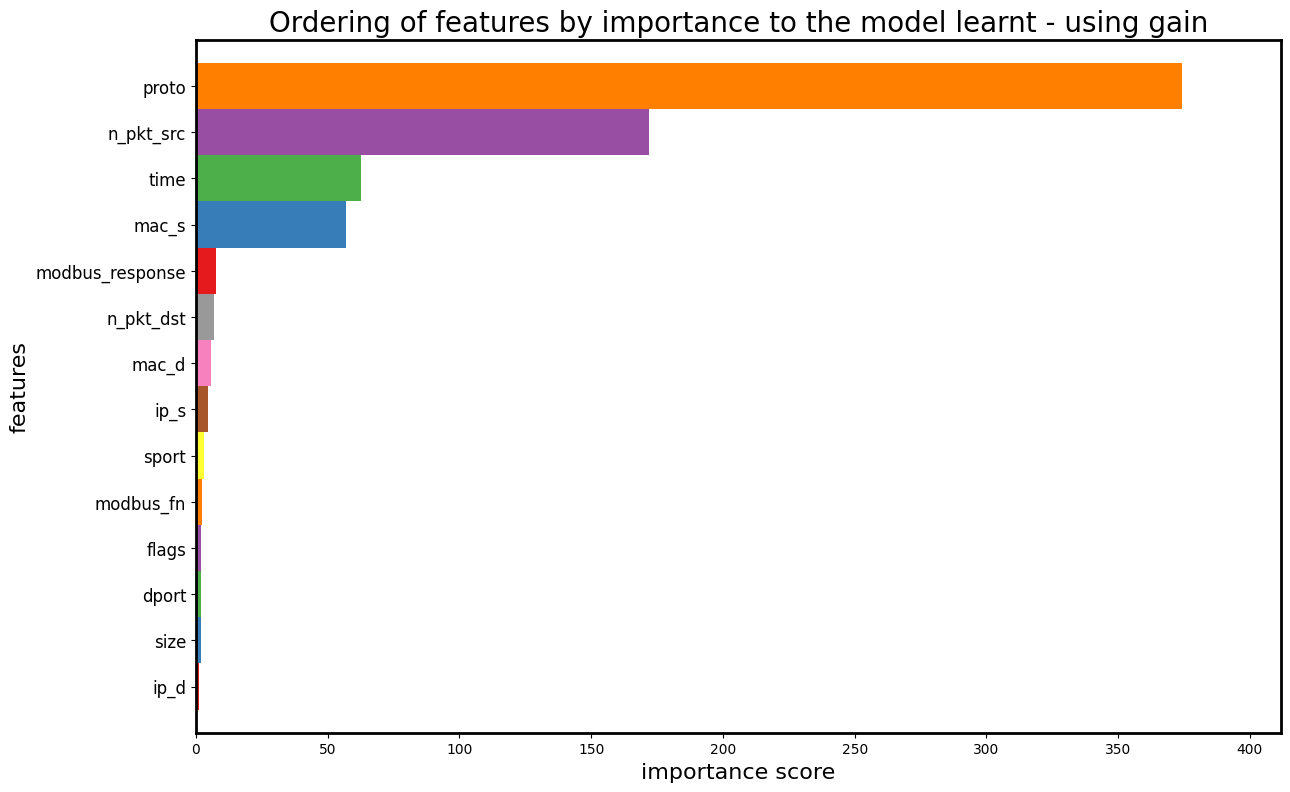

In [85]:
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))
ax = xgb.plot_importance(model, height=1, ax=ax, color=colours, grid=False, show_values=False, importance_type='gain')

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)

ax.set_xlabel('importance score', size=16)
ax.set_ylabel('features', size=16)
ax.set_yticklabels(ax.get_yticklabels(), size=12)
ax.set_title('Ordering of features by importance to the model learnt - using gain', size=20)

Text(0.5, 1.0, 'Ordering of features by importance to the model learnt - using cover')

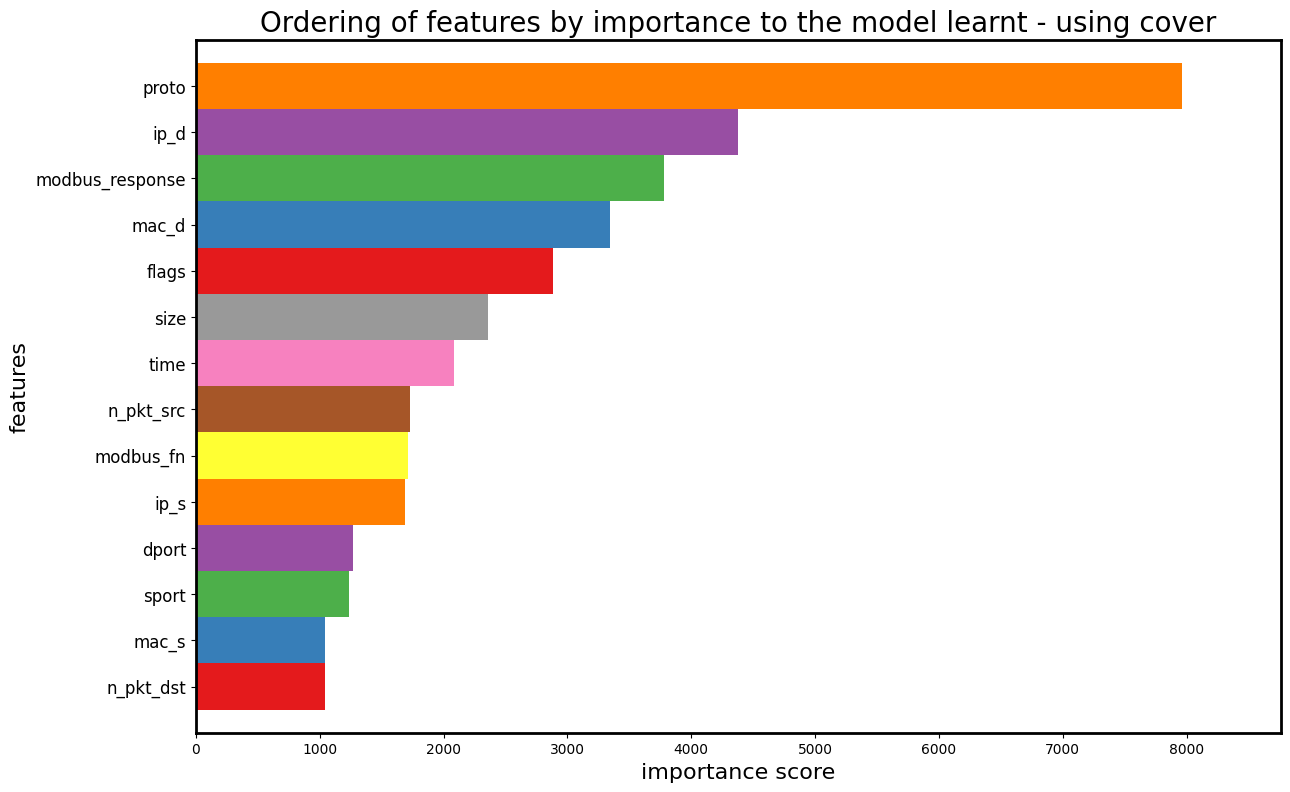

In [86]:
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))
ax = xgb.plot_importance(model, height=1, ax=ax, color=colours, grid=False, show_values=False, importance_type='cover')

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)

ax.set_xlabel('importance score', size=16)
ax.set_ylabel('features', size=16)
ax.set_yticklabels(ax.get_yticklabels(), size=12)
ax.set_title('Ordering of features by importance to the model learnt - using cover', size=20)

In [68]:
# let's try to do multi class classification
dtrain = xgb.DMatrix(X_train, label=y_train["new_labels"], enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test["new_labels"], enable_categorical=True)

params = {"objective": "multi:softmax", "tree_method": "hist", "seed": random_state, "num_class": len(y_train["new_labels"].unique())}
n = 200

evals = [(dtest, "validation"), (dtrain, "train")]

model = xgb.train(params, dtrain, n, evals=evals, verbose_eval=10)

/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/xgboost/data.py:463: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/xgboost/data.py:464: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_categorical_dtype(dtype) and enable_categorical)
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/theoripoll/.pyenv/versions/3.11.2/envs/env_MLSECU_PROJECT/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype 

[0]	validation-mlogloss:1.06293	train-mlogloss:1.06305
[10]	validation-mlogloss:0.23623	train-mlogloss:0.23469
[20]	validation-mlogloss:0.17955	train-mlogloss:0.17766
[30]	validation-mlogloss:0.16275	train-mlogloss:0.15974
[40]	validation-mlogloss:0.15631	train-mlogloss:0.15215
[50]	validation-mlogloss:0.15302	train-mlogloss:0.14793
[60]	validation-mlogloss:0.15155	train-mlogloss:0.14536
[70]	validation-mlogloss:0.15059	train-mlogloss:0.14357
[80]	validation-mlogloss:0.15013	train-mlogloss:0.14240
[90]	validation-mlogloss:0.14953	train-mlogloss:0.14102
[100]	validation-mlogloss:0.14936	train-mlogloss:0.14004
[110]	validation-mlogloss:0.14920	train-mlogloss:0.13916
[120]	validation-mlogloss:0.14915	train-mlogloss:0.13827
[130]	validation-mlogloss:0.14929	train-mlogloss:0.13766
[140]	validation-mlogloss:0.14930	train-mlogloss:0.13696
[150]	validation-mlogloss:0.14933	train-mlogloss:0.13625
[160]	validation-mlogloss:0.14943	train-mlogloss:0.13564
[170]	validation-mlogloss:0.14943	train-ml

In [78]:
preds = model.predict(dtest)

In [79]:
print("Accuracy: ", accuracy_score(y_test["new_labels"], preds.round()))
print("Precision: ", precision_score(y_test["new_labels"], preds.round(), average="macro"))
print("Recall: ", recall_score(y_test["new_labels"], preds.round(), average="macro"))
print("F1: ", f1_score(y_test["new_labels"], preds.round(), average="macro"))

Accuracy:  0.9236006829448913
Precision:  0.8762066989386907
Recall:  0.8153400326432166
F1:  0.837859341303392


<Axes: >

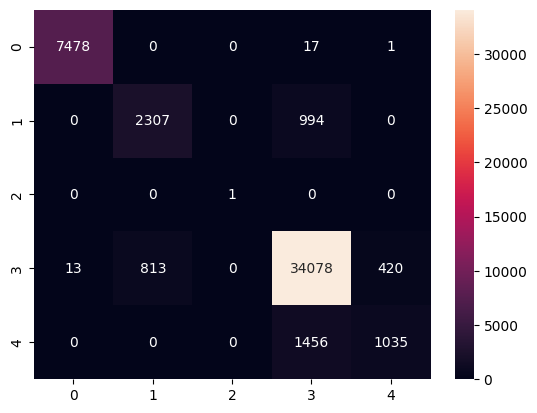

In [80]:
confusion_matrix(y_test["new_labels"], preds.round())
sns.heatmap(confusion_matrix(y_test["new_labels"], preds.round()), annot=True, fmt="d")